## Practica de Spark

###### Abraham Buenrostro Cruces

##### Descripcion: 
Aplicar los conceptos fundamentales de Spark (RDDs, DataFrames, transformaciones y acciones) para realizar un análisis distribuido de datos reales o semi-reales sobre movilidad urbana.
El gobierno de la Ciudad de México publica datos abiertos sobre movilidad, tránsito y transporte público. Para esta tarea, el estudiante trabajará con un dataset que simule (o se base en) registros de viajes de transporte público, GPS de unidades o bicis compartidas.

El objetivo es realizar un análisis que responda a preguntas como:

* ¿Cuáles son las rutas con mayor congestión?
* ¿En qué horarios hay más viajes?
* ¿Qué zonas tienen más entrada o salida de vehículos?

El análisis debe incluir:

* Lectura de datos en formato CSV o JSON.
* Uso de y , con transformaciones y acciones.
* Al menos una operación de agregación distribuida (por ejemplo, reduceByKey, groupBy).
* Aplicación de filtros, mapas y joins (si aplica).
* Generación de un resumen en un archivo CSV o visualización simple (opcional con matplotlib o similar).

Se puede utilizar PySpark o Spark con Scala.
Pueden consultar IA para resolver dudas de sintaxis.
Deben documentar en el informe qué consultas hicieron a IA, en qué parte del código se usaron y cómo ayudaron.
con:
* Descripción del dataset (fuente o cómo se generó si es sintético).
* Explicación de las operaciones realizadas y por qué se usaron.
* Análisis de los resultados.
* Fragmentos clave de código con comentarios.
* Reflexión sobre qué partes se pudieron distribuir eficientemente y cuáles no.

organizado y ejecutable en entorno local o en Databricks.

##### Criterio Ponderación
* Aplicación correcta de operaciones Spark 40%
* Calidad del análisis y justificación 20%
* Documentación y claridad del informe 20%
* Uso ético y documentado de IA como herramienta auxiliar 10%
* Organización del código y reproducibilidad 10%

## Análisis de Movilidad Urbana en la Ciudad de México con Apache Spark

#### Importar librerias.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql.functions import *


Validacion de Pyspark

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Analisis Ecobicis") \
    .getOrCreate()

spark


### Obtención de Datos de Movilidad de la CDMX

In [86]:
# Cargar el archivo CSV en un DataFrame
df = spark.read.csv("2025-03.csv", header=True, inferSchema=True)
# Mostrar los primeros  
df.show(10)
# Mostrar el esquema del DataFrame
df.printSchema()

+--------------+------------+-------+---------------------+------------+-------------------+--------------------+------------+-------------------+
|Genero_Usuario|Edad_Usuario|   Bici|Ciclo_Estacion_Retiro|Fecha_Retiro|        Hora_Retiro|Ciclo_EstacionArribo|Fecha_Arribo|        Hora_Arribo|
+--------------+------------+-------+---------------------+------------+-------------------+--------------------+------------+-------------------+
|             M|          29|3021250|                  263|  28/02/2025|2025-05-04 23:46:00|                 116|  01/03/2025|2025-05-04 00:00:08|
|             M|          30|8828782|                  060|  28/02/2025|2025-05-04 23:50:06|                 128|  01/03/2025|2025-05-04 00:00:10|
|             M|          26|7379795|                  036|  28/02/2025|2025-05-04 23:56:44|                 037|  01/03/2025|2025-05-04 00:00:10|
|             M|          24|3012796|                  154|  28/02/2025|2025-05-04 23:27:12|                 542|  01/

### Exploracion de los datos

In [14]:
df.printSchema()
df = df.dropna(how='all')



root
 |-- Genero_Usuario: string (nullable = true)
 |-- Edad_Usuario: string (nullable = true)
 |-- Bici: integer (nullable = true)
 |-- Ciclo_Estacion_Retiro: string (nullable = true)
 |-- Fecha_Retiro: string (nullable = true)
 |-- Hora_Retiro: timestamp (nullable = true)
 |-- Ciclo_EstacionArribo: string (nullable = true)
 |-- Fecha_Arribo: string (nullable = true)
 |-- Hora_Arribo: timestamp (nullable = true)



In [85]:
spark.sql("SELECT COUNT(*) AS Total_Registros FROM Ecobicis").show()


+---------------+
|Total_Registros|
+---------------+
|        1832349|
+---------------+



### Limpieza de datos

In [15]:
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

+--------------+------------+----+---------------------+------------+-----------+--------------------+------------+-----------+
|Genero_Usuario|Edad_Usuario|Bici|Ciclo_Estacion_Retiro|Fecha_Retiro|Hora_Retiro|Ciclo_EstacionArribo|Fecha_Arribo|Hora_Arribo|
+--------------+------------+----+---------------------+------------+-----------+--------------------+------------+-----------+
|             0|           0|   0|                    0|           0|          0|                   0|           0|          0|
+--------------+------------+----+---------------------+------------+-----------+--------------------+------------+-----------+



In [16]:
from pyspark.sql.functions import countDistinct

df.select([
    countDistinct(col(c)).alias(c)
    for c in df.columns
]).show()


+--------------+------------+----+---------------------+------------+-----------+--------------------+------------+-----------+
|Genero_Usuario|Edad_Usuario|Bici|Ciclo_Estacion_Retiro|Fecha_Retiro|Hora_Retiro|Ciclo_EstacionArribo|Fecha_Arribo|Hora_Arribo|
+--------------+------------+----+---------------------+------------+-----------+--------------------+------------+-----------+
|             4|          80|7109|                  678|          41|      69871|                 678|          31|      71167|
+--------------+------------+----+---------------------+------------+-----------+--------------------+------------+-----------+



In [24]:
df.groupBy("Fecha_Retiro").count().orderBy("Fecha_Retiro").show(41)


+------------+-----+
|Fecha_Retiro|count|
+------------+-----+
|  01/03/2025|44850|
|  02/03/2025|42927|
|  03/03/2025|69615|
|  04/03/2025|74458|
|  05/03/2025|73465|
|  05/12/2024|    1|
|  06/02/2025|    1|
|  06/03/2025|71886|
|  07/03/2025|70984|
|  08/03/2025|45045|
|  09/03/2025|43869|
|  10/03/2025|67697|
|  11/03/2025|69671|
|  12/03/2025|69766|
|  13/03/2025|70254|
|  14/03/2025|67580|
|  15/03/2025|40846|
|  16/03/2025|39471|
|  17/03/2025|35390|
|  17/11/2024|    1|
|  18/03/2025|67799|
|  19/03/2025|71772|
|  20/03/2025|66308|
|  21/03/2025|62306|
|  22/02/2025|    1|
|  22/03/2025|40548|
|  23/03/2025|40344|
|  24/03/2025|63483|
|  25/01/2025|    1|
|  25/02/2025|    1|
|  25/03/2025|61441|
|  26/02/2025|    1|
|  26/03/2025|64776|
|  26/05/2024|    1|
|  27/03/2025|70400|
|  28/02/2025|  229|
|  28/03/2025|66632|
|  29/03/2025|50981|
|  30/03/2025|42311|
|  30/04/2023|    1|
|  31/03/2025|65474|
+------------+-----+



In [25]:
df = df.filter(df.Fecha_Retiro.endswith("/03/2025"))

In [26]:
from pyspark.sql.functions import countDistinct

df.select([
    countDistinct(col(c)).alias(c)
    for c in df.columns
]).show()


+--------------+------------+----+---------------------+------------+-----------+--------------------+------------+-----------+
|Genero_Usuario|Edad_Usuario|Bici|Ciclo_Estacion_Retiro|Fecha_Retiro|Hora_Retiro|Ciclo_EstacionArribo|Fecha_Arribo|Hora_Arribo|
+--------------+------------+----+---------------------+------------+-----------+--------------------+------------+-----------+
|             4|          80|7104|                  678|          31|      69869|                 678|          31|      71163|
+--------------+------------+----+---------------------+------------+-----------+--------------------+------------+-----------+



¿En que estaciones se pidieron más ecobicis durante el mes de marzo?

In [87]:
# Registrar el DataFrame como una tabla temporal
df.createOrReplaceTempView("Ecobicis")
# Realizar una consulta SQL para contar el número de viajes por estación de origen
df_estaciones_origen = spark.sql("""
    SELECT Ciclo_Estacion_Retiro, COUNT(*) AS Total_Viajes
    FROM Ecobicis
    GROUP BY Ciclo_Estacion_Retiro
    ORDER BY Total_Viajes DESC
""")

df_estaciones_origen.show(10)


+---------------------+------------+
|Ciclo_Estacion_Retiro|Total_Viajes|
+---------------------+------------+
|              271-272|       12521|
|                  548|       10734|
|                  027|       10715|
|              107-108|       10479|
|                  064|       10037|
|              237-238|        9402|
|                  018|        8872|
|              273-274|        8641|
|                  014|        8637|
|              192-193|        8625|
+---------------------+------------+
only showing top 10 rows



¿Cuales fueron las principales estaciones destino de Ecobici en el mes de marzo?

In [32]:
# Realizar una consulta SQL para contar el número de viajes por estación de destino
print("Consulta SQL: Número de viajes por estación de destino") 
spark.sql("SELECT Ciclo_EstacionArribo, COUNT(*) AS Total_Viajes FROM Ecobicis GROUP BY Ciclo_EstacionArribo").show(10)

Consulta SQL: Número de viajes por estación de destino
+--------------------+------------+
|Ciclo_EstacionArribo|Total_Viajes|
+--------------------+------------+
|                 691|         970|
|                 467|        2832|
|                 675|        2471|
|                 296|        1869|
|                 125|        3777|
|                 451|        1174|
|                 666|         511|
|                 124|        2927|
|                 447|        3450|
|                 591|        2261|
+--------------------+------------+
only showing top 10 rows



¿Que genero fue el principal usuario de Ecobici durante el mes de marzo?

In [59]:
df_genero = spark.sql("""
    SELECT Genero_Usuario, COUNT(*) AS Total_Personas
    FROM Ecobicis
    GROUP BY Genero_Usuario
""")
df_genero.show()


+--------------+--------------+
|Genero_Usuario|Total_Personas|
+--------------+--------------+
|             F|        514543|
|             M|       1250070|
|             O|         34717|
|             ?|         33019|
+--------------+--------------+



In [60]:
pdf_genero = df_genero.toPandas()


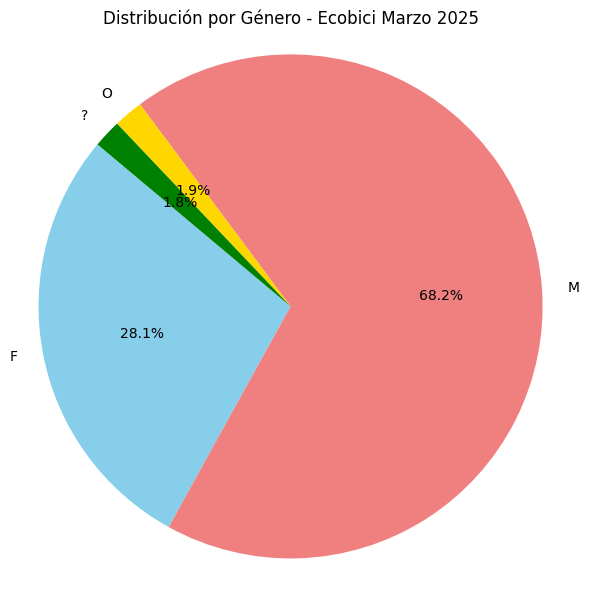

In [62]:
# Extraer datos
labels = pdf_genero["Genero_Usuario"]
sizes = pdf_genero["Total_Personas"]

# Crear gráfico de pastel
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=["skyblue", "lightcoral", "gold","green"])
plt.title("Distribución por Género - Ecobici Marzo 2025")
plt.axis("equal")  # Asegura que el gráfico sea un círculo
plt.tight_layout()
plt.show()

¿De que edad fueron principalmente los usuarios de Ecobici durante el mes de marzo?

In [37]:
print("Consulta SQL: Número de viajes por edad")
spark.sql("""
    SELECT Edad_Usuario, COUNT(*) AS Total_Viajes
    FROM Ecobicis
    GROUP BY Edad_Usuario
    ORDER BY Total_Viajes DESC
""").show(50, truncate=False)
# Contar cuántas personas hay por edad


Consulta SQL: Número de viajes por edad
+------------+------------+
|Edad_Usuario|Total_Viajes|
+------------+------------+
|30          |95134       |
|29          |93799       |
|31          |92351       |
|27          |92207       |
|28          |91788       |
|32          |84231       |
|25          |80871       |
|26          |80632       |
|33          |76932       |
|34          |72482       |
|24          |71701       |
|35          |68741       |
|36          |61032       |
|23          |57833       |
|37          |54442       |
|38          |46533       |
|39          |46408       |
|22          |44673       |
|41          |39675       |
|40          |39399       |
|21          |35724       |
|42          |35373       |
|43          |30304       |
|44          |30302       |
|20          |27570       |
|45          |25644       |
|46          |20359       |
|47          |19414       |
|48          |19384       |
|19          |18326       |
|49          |17648       |
|50     

In [76]:
# Consulta para agrupar por rangos de edad (por cada 10 años)
spark.sql("""
    SELECT
        CASE
            WHEN Edad_Usuario >= 0 AND Edad_Usuario <= 9 THEN '0-9'
            WHEN Edad_Usuario >= 10 AND Edad_Usuario <= 19 THEN '10-19'
            WHEN Edad_Usuario >= 20 AND Edad_Usuario <= 29 THEN '20-29'
            WHEN Edad_Usuario >= 30 AND Edad_Usuario <= 39 THEN '30-39'
            WHEN Edad_Usuario >= 40 AND Edad_Usuario <= 49 THEN '40-49'
            WHEN Edad_Usuario >= 50 AND Edad_Usuario <= 59 THEN '50-59'
            WHEN Edad_Usuario >= 60 AND Edad_Usuario <= 69 THEN '60-69'
            WHEN Edad_Usuario >= 70 AND Edad_Usuario <= 79 THEN '70-79'
            ELSE '80+' 
        END AS Rango_Edad,
        COUNT(*) AS Total_Viajes
    FROM Ecobicis
    GROUP BY Rango_Edad
    ORDER BY Total_Viajes DESC
""").show()


+----------+------------+
|Rango_Edad|Total_Viajes|
+----------+------------+
|     30-39|      698286|
|     20-29|      676798|
|     40-49|      277502|
|     50-59|      113305|
|     60-69|       33579|
|     10-19|       27115|
|     70-79|        5008|
|       80+|         756|
+----------+------------+



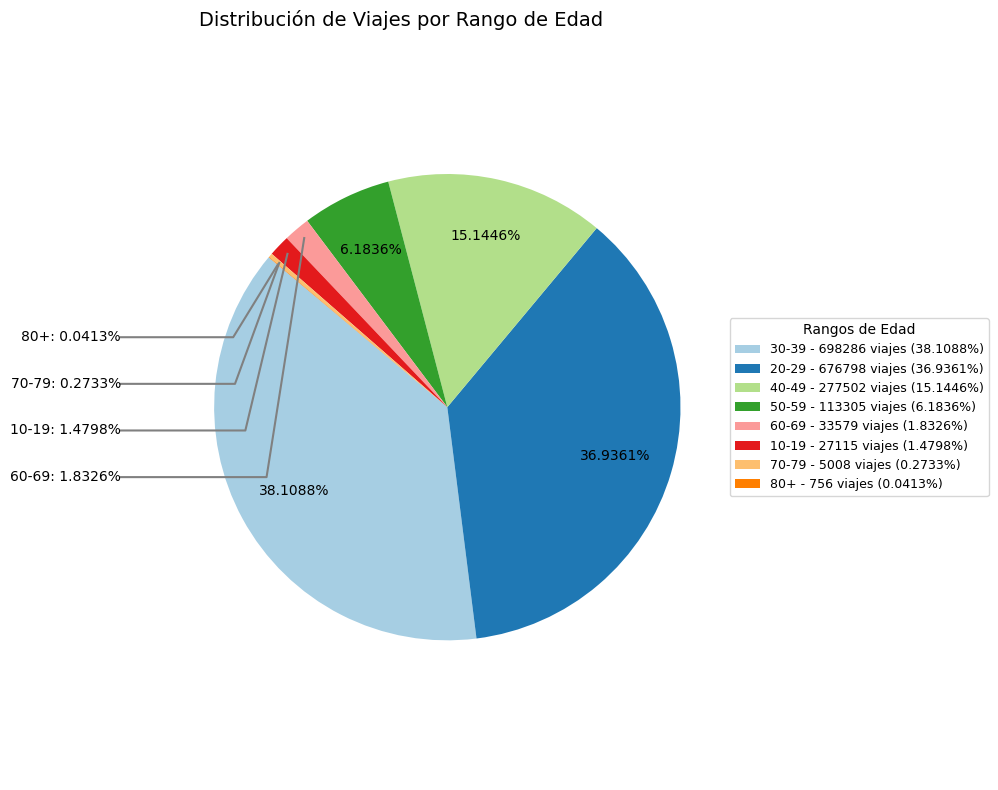

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir el DataFrame de Spark a Pandas
df_edad_rangos = spark.sql("""
    SELECT
        CASE
            WHEN Edad_Usuario >= 0 AND Edad_Usuario <= 9 THEN '0-9'
            WHEN Edad_Usuario >= 10 AND Edad_Usuario <= 19 THEN '10-19'
            WHEN Edad_Usuario >= 20 AND Edad_Usuario <= 29 THEN '20-29'
            WHEN Edad_Usuario >= 30 AND Edad_Usuario <= 39 THEN '30-39'
            WHEN Edad_Usuario >= 40 AND Edad_Usuario <= 49 THEN '40-49'
            WHEN Edad_Usuario >= 50 AND Edad_Usuario <= 59 THEN '50-59'
            WHEN Edad_Usuario >= 60 AND Edad_Usuario <= 69 THEN '60-69'
            WHEN Edad_Usuario >= 70 AND Edad_Usuario <= 79 THEN '70-79'
            ELSE '80+' 
        END AS Rango_Edad,
        COUNT(*) AS Total_Viajes
    FROM Ecobicis
    GROUP BY Rango_Edad
    ORDER BY Total_Viajes DESC
""").toPandas()

# Preparar datos
total_viajes = df_edad_rangos['Total_Viajes'].sum()
porcentajes = df_edad_rangos['Total_Viajes'] / total_viajes * 100
colores = plt.cm.Paired(range(len(df_edad_rangos)))

fig, ax = plt.subplots(figsize=(10, 8))

# Dibujar el pastel
wedges, texts, autotexts = ax.pie(
    df_edad_rangos['Total_Viajes'],
    labels=None,
    autopct='%1.4f%%',  # Cambiar aquí a 4 decimales
    startangle=140,
    colors=colores,
    pctdistance=0.75
)

# Ajustar texto: últimos 4 segmentos
n = len(df_edad_rangos)
indices_externos = range(n - 4, n)
salto_y = [-0.3, -0.1, 0.1, 0.3]  # Espaciado vertical para evitar encimado

for j, i in enumerate(indices_externos):
    # Calcular ángulo medio del segmento
    angle = (wedges[i].theta2 + wedges[i].theta1) / 2
    rad = np.deg2rad(angle)
    x = np.cos(rad)
    y = np.sin(rad)

    # Punto desde donde sale la línea (en el borde del círculo)
    x0, y0 = 0.95 * x, 0.95 * y
    # Punto de la etiqueta desplazado con línea horizontal
    align = 'left' if x >= 0 else 'right'
    x_text = 1.4 * np.sign(x)
    y_text = salto_y[j]

    # Dibujar la línea con segmento horizontal final
    ax.plot([x0, 1.2 * x, x_text], [y0, y_text, y_text], color='gray')
    ax.text(x_text, y_text, f"{df_edad_rangos['Rango_Edad'][i]}: {porcentajes[i]:.4f}%", ha=align, va='center', fontsize=10)

    # Ocultar porcentaje dentro del pastel
    autotexts[i].set_visible(False)

# Título y leyenda
ax.set_title("Distribución de Viajes por Rango de Edad", fontsize=14)
labels = [f"{rango} - {viajes} viajes ({porcentaje:.4f}%)" for rango, viajes, porcentaje in zip(df_edad_rangos['Rango_Edad'], df_edad_rangos['Total_Viajes'], porcentajes)]
ax.legend(wedges, labels, title="Rangos de Edad", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)

# Mantener proporción circular
ax.axis('equal')

plt.tight_layout()
plt.show()


¿Que días tuvieron mas afluencia de usuarios en Ecobici durante el mes de marzo?

In [58]:
df_por_dia = spark.sql("""
    SELECT Fecha_Retiro, COUNT(*) AS Total_Viajes
    FROM Ecobicis
    GROUP BY Fecha_Retiro
    ORDER BY Total_Viajes DESC
""")
df_por_dia.show(50, truncate=False)

+------------+------------+
|Fecha_Retiro|Total_Viajes|
+------------+------------+
|04/03/2025  |74458       |
|05/03/2025  |73465       |
|06/03/2025  |71886       |
|19/03/2025  |71772       |
|07/03/2025  |70984       |
|27/03/2025  |70400       |
|13/03/2025  |70254       |
|12/03/2025  |69766       |
|11/03/2025  |69671       |
|03/03/2025  |69615       |
|18/03/2025  |67799       |
|10/03/2025  |67697       |
|14/03/2025  |67580       |
|28/03/2025  |66632       |
|20/03/2025  |66308       |
|31/03/2025  |65474       |
|26/03/2025  |64776       |
|24/03/2025  |63483       |
|21/03/2025  |62306       |
|25/03/2025  |61441       |
|29/03/2025  |50981       |
|08/03/2025  |45045       |
|01/03/2025  |44850       |
|09/03/2025  |43869       |
|02/03/2025  |42927       |
|30/03/2025  |42311       |
|15/03/2025  |40846       |
|22/03/2025  |40548       |
|23/03/2025  |40344       |
|16/03/2025  |39471       |
|17/03/2025  |35390       |
+------------+------------+



In [54]:
pdf_por_dia = df_por_dia.toPandas()
pdf_por_dia["Fecha_Retiro"] = pd.to_datetime(pdf_por_dia["Fecha_Retiro"], format="%d/%m/%Y")

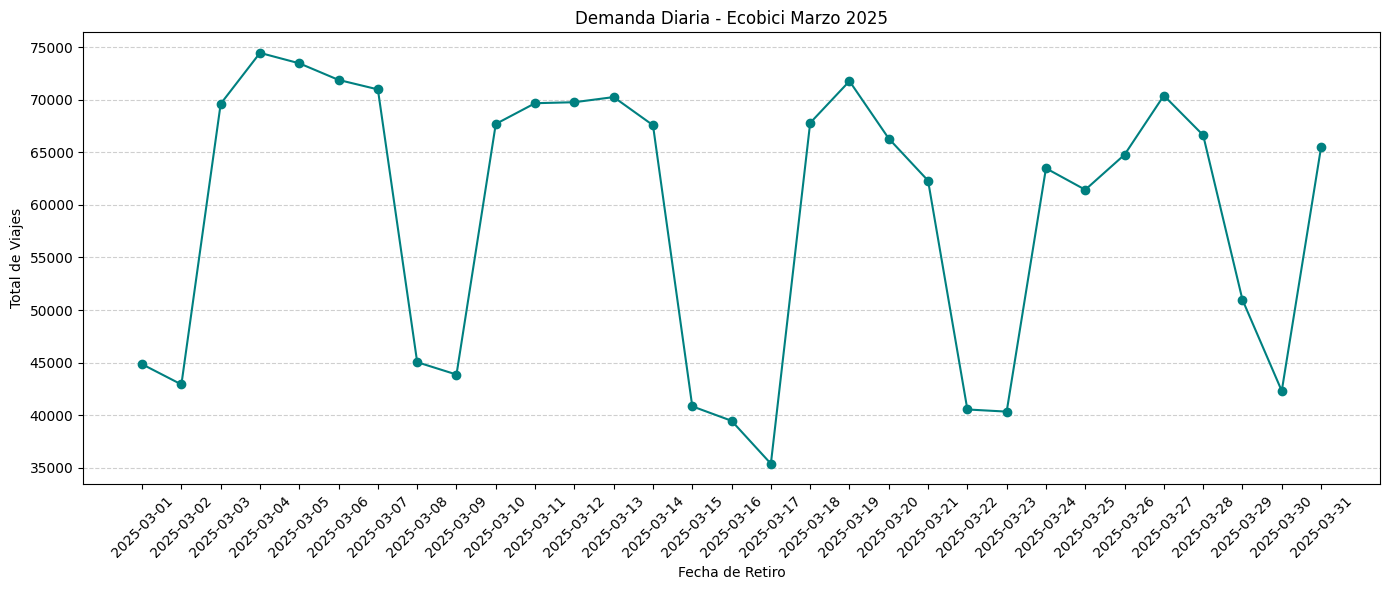

In [57]:
pdf_por_dia["Fecha_Retiro"] = pd.to_datetime(pdf_por_dia["Fecha_Retiro"], format="%d/%m/%Y")
pdf_por_dia = pdf_por_dia.sort_values("Fecha_Retiro")

plt.figure(figsize=(14, 6))
plt.plot(pdf_por_dia["Fecha_Retiro"], pdf_por_dia["Total_Viajes"], marker='o', linestyle='-', color='teal')

plt.xlabel("Fecha de Retiro")
plt.ylabel("Total de Viajes")
plt.title("Demanda Diaria - Ecobici Marzo 2025")
plt.xticks(pdf_por_dia["Fecha_Retiro"], rotation=45)

plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Afluencia por hora

In [48]:
df_retiros_por_hora = spark.sql("""
    SELECT hour(Hora_Retiro) AS Hora, COUNT(*) AS Total_Viajes
    FROM Ecobicis
    GROUP BY hour(Hora_Retiro)
    ORDER BY Total_Viajes DESC
""")




In [49]:
pdf_retiros = df_retiros_por_hora.toPandas()
pdf_retiros = pdf_retiros.sort_values("Hora")  # Ordena por hora para graficar


Afluencia de llegada de usuarios a estaciones de ecobici durante el mes de marzo.

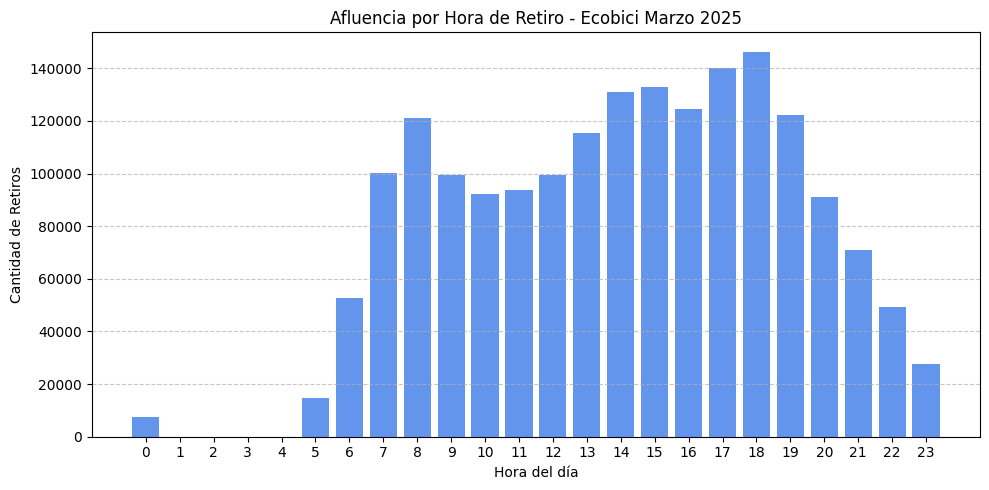

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(pdf_retiros["Hora"], pdf_retiros["Total_Viajes"], color="cornflowerblue")

plt.xlabel("Hora del día")
plt.ylabel("Cantidad de Retiros")
plt.title("Afluencia por Hora de Retiro - Ecobici Marzo 2025")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [45]:
df_arribos_por_hora = spark.sql("""
    SELECT hour(Hora_Arribo) AS Hora, COUNT(*) AS Total_Viajes
    FROM Ecobicis
    GROUP BY hour(Hora_Arribo)
    ORDER BY Total_Viajes DESC
""")
df_arribos_por_hora.show(24, truncate=False)



+----+------------+
|Hora|Total_Viajes|
+----+------------+
|18  |147632      |
|17  |133426      |
|15  |132731      |
|14  |130477      |
|19  |129956      |
|16  |124477      |
|8   |119153      |
|13  |112476      |
|9   |104693      |
|20  |100546      |
|12  |97327       |
|11  |92402       |
|10  |91145       |
|7   |88030       |
|21  |75497       |
|22  |54946       |
|6   |42170       |
|23  |32853       |
|0   |11725       |
|5   |10194       |
|1   |432         |
|2   |35          |
|4   |14          |
|3   |12          |
+----+------------+



In [46]:
df_arribos_por_hora = df_arribos_por_hora.toPandas()


Afluencia por hora de arribo de usuarios de Ecobici a las estaciones.

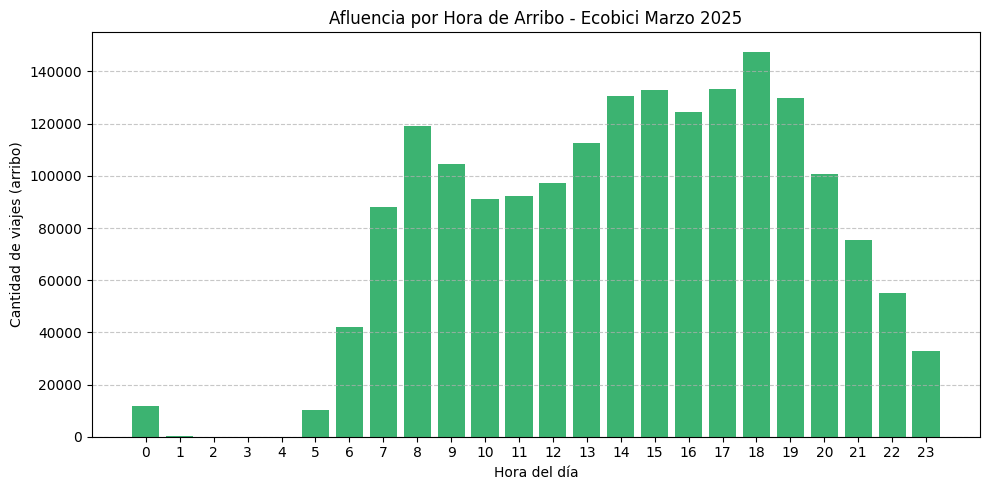

In [47]:
import matplotlib.pyplot as plt

# Ordenar por hora (ya que el SQL lo ordenó por Total_Viajes)
pdf_sorted = df_arribos_por_hora.sort_values("Hora")

plt.figure(figsize=(10, 5))
plt.bar(pdf_sorted["Hora"], pdf_sorted["Total_Viajes"], color="mediumseagreen")

plt.xlabel("Hora del día")
plt.ylabel("Cantidad de viajes (arribo)")
plt.title("Afluencia por Hora de Arribo - Ecobici Marzo 2025")
plt.xticks(range(24))  # Asegura que estén las 24 horas
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
